## Theme discovery using the Universal Sentence Encoder and PCA
### Plus application of gender-neutral sentiment analysis classifier

Copyright (C) 2023 by the Regents of the University of California and licensed under the Apache License, Version 2.0

In [20]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# Load prerequisite libraries
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
import re
import seaborn as sns
%matplotlib inline

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

import tensorflow_text as text

MIN_SENTENCE_LENGTH = 6 #min number of characters in a sentence

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [3]:
# Load feedback data

file = 'BBOT2021new.xls'  # Our dataset was contained in this excel file, replace this with your own dataset as appropriate
df = pd.read_excel(file)

In [4]:
# Process feedback data
# The code here is specific to the format of the dataset we used and should be modified for other datasets as appropriate

#replace fancy ' character for contractions
tdf_feedback = df['Feedback'].str.replace('’', '\'')
tdf_feedback = tdf_feedback.str.replace('‘', '\'')
df_feedback = list(map(str, tdf_feedback))

df_writer = df['Learner/Observer']
df_trust_level = np.asanyarray(df['Supervision rating'])
df_gender = df['Gender']
df_UIM = np.asanyarray(list(map(int,np.nan_to_num(df['UIM']))))
df_level = df['Level']

#convert observer/ learner into enumerated code
switcher = { 
    'Observer':0,
    'Learner':1
}
print(switcher)
df_writer_binary = []
for x in df_writer:
    df_writer_binary.append(switcher.get(x,''))
df_writer_binary = np.asanyarray(df_writer_binary)
    
#convert gender into enumerated code
switcher = { 
    'M':0,
    'F':1,
    'X':2
}
print(switcher)
df_gender_binary = []
for x in df_gender:
    df_gender_binary.append(switcher.get(x,''))
df_gender_binary = np.asanyarray(list(map(int,df_gender_binary)))

#convert student level into enumerated code
switcher = { 
    '3A':0,
    '3B':1,
    '3M':1,
    '4A':2,
    '4B':3
}
print(switcher)
df_level_binary = []
for x in df_level:
    df_level_binary.append(switcher.get(x,''))
df_level_binary = np.asanyarray(df_level_binary)
    
print(df_trust_level)
print(df_writer_binary)
print(df_UIM)
print(df_gender_binary)
print(df_level_binary)

{'Observer': 0, 'Learner': 1}
{'M': 0, 'F': 1, 'X': 2}
{'3A': 0, '3B': 1, '3M': 1, '4A': 2, '4B': 3}
[2 4 2 ... 3 3 3]
[0 0 0 ... 1 1 0]
[0 1 1 ... 0 0 1]
[0 0 1 ... 1 1 1]
[3 3 3 ... 3 3 0]


In [ ]:
# Split narrative feedback into sentences if desired:
# We did not ultimately use this section in the analysis, but it causes the analysis to be performed 
# on a 'by sentence' basis, instead of by each feedback narrative, if desired

import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

num_sentences = 0
fb_sentences = []
df_trust_level_by_sentence = []
df_writer_binary_by_sentence = []
df_writer_by_sentence = []
df_course_by_sentence = []
df_observer_by_sentence = []
df_skill_by_sentence = []

for i,fb in enumerate(df_feedback): 
    #add space after period if period followed by upper case letter
    last_pos = -1
    for n in range(fb.count('.')):
        last_pos = fb.find('.', last_pos + 1)
        if (len(fb) > last_pos + 1):
            if (fb[last_pos+1].isupper()):
                old_text = fb[0:last_pos]
                new_text = fb[last_pos+1:] 
                fb = old_text + '. ' + new_text
    
    temp_sentences = tokenizer.tokenize(fb)
    for temp_sentence in temp_sentences:
        if len(temp_sentence) > MIN_SENTENCE_LENGTH:
            fb_sentences.append(temp_sentence)
            df_trust_level_by_sentence.append(df_trust_level[i])
            df_writer_binary_by_sentence.append(df_writer_binary[i])
            df_writer_by_sentence.append(df_writer[i])
            df_course_by_sentence.append(df['Course'][i])
            df_observer_by_sentence.append(str.lower(df['Observer'][i]))
            df_skill_by_sentence.append(str.lower(df['Skill Observed'][i][0:4]))
            num_sentences += 1

print('number of sentences: %s' % num_sentences)

In [9]:
# If processing by each feedback narrative (rather than by sentences), run the following:

fb_sentences = df_feedback
df_trust_level_by_sentence = df_trust_level
df_writer_binary_by_sentence = df_writer_binary

In [10]:
# Load the trained sentiment classifier model (see the Sentiment_classifier... notebook)

reloaded_model = tf.saved_model.load('./imdb_experts_pubmed_BERT-PubMed-GenderNeutral')

In [12]:
# Test sentiment classier model 

print(tf.sigmoid(reloaded_model(tf.constant(['Good job doing a comprehensive history and physical examination on a patient with exacerbation of congestive heart failure. I was impressed with the level of detail and the thoroughness of the presentation. As we discussed, I would start to think about what information needs to be a part of an oral presentation, versus what important information can simply be recorded in your written note for reference. This will help to make presentations more concise and easier to follow. Great start!']))))
print(tf.sigmoid(reloaded_model(tf.constant(['Good job doing a comprehensive history and physical examination on a patient with exacerbation of congestive heart failure. However, I was not impressed with the level of detail and the thoroughness of the presentation. As we discussed, I would start to think about what information needs to be a part of an oral presentation, versus what important information can simply be recorded in your written note for reference. This will help to make presentations more concise and easier to follow. Great start!']))))
print(tf.sigmoid(reloaded_model(tf.constant(['Gave an inadequately comprehensive history and physical examination on a patient with exacerbation of congestive heart failure. Further, I was not impressed with the level of detail and the thoroughness of the presentation. As we discussed, I would start to think about what information needs to be a part of an oral presentation, versus what important information can simply be recorded in your written note for reference. This will help to make presentations more concise and easier to follow. Great start!']))))

print(tf.sigmoid(reloaded_model(tf.constant(['They did a good job doing a comprehensive history and physical examination on a patient with exacerbation of congestive heart failure, but I was not impressed with the level of detail and the thoroughness of the presentation. As we discussed, I would start to think about what information needs to be a part of an oral presentation, versus what important information can simply be recorded in your written note for reference. This will help to make presentations more concise and easier to follow. Great start!']))))
print(tf.sigmoid(reloaded_model(tf.constant(['He did a good job doing a comprehensive history and physical examination on a patient with exacerbation of congestive heart failure, but I was not impressed with the level of detail and the thoroughness of the presentation. As we discussed, I would start to think about what information needs to be a part of an oral presentation, versus what important information can simply be recorded in your written note for reference. This will help to make presentations more concise and easier to follow. Great start!']))))
print(tf.sigmoid(reloaded_model(tf.constant(['She did a good job doing a comprehensive history and physical examination on a patient with exacerbation of congestive heart failure, but I was not impressed with the level of detail and the thoroughness of the presentation. As we discussed, I would start to think about what information needs to be a part of an oral presentation, versus what important information can simply be recorded in your written note for reference. This will help to make presentations more concise and easier to follow. Great start!']))))

tf.Tensor([[0.98833615]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5749663]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.22850722]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.47187346]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.55546206]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.542203]], shape=(1, 1), dtype=float32)



In [13]:
# Define functions to remove gendered pronouns and nouns

pronouns_gendered = ['himself', 'herself', 'him', 'her', 'he', 'she', 'his', 'hers', 'he\'s', 'she\'s', 
                     'guys', 'gals', 'man', 'woman', 'guy', 'gal', 'men', 'women', 'girl', 'boy']
pronouns_nongendered = ['themself', 'themself', 'them', 'them', 'they', 'they', 'their', 'their', 'they\'re', 'they\'re', 
                        'people', 'people', 'person', 'person', 'person', 'person', 'people', 'people', 'young person', 'young person']


def remove_gender(b_sentence):
    new_sentence = ''
    sentence = b_sentence #str(b_sentence,'utf-8')
    #print(len(sentence))
    #print(sentence)
    for word in sentence.split():
        if word.lower() in pronouns_gendered:
            new_sentence += pronouns_nongendered[pronouns_gendered.index(word.lower())] + ' '
        elif word.rstrip('.').lower() in pronouns_gendered:
            new_sentence += pronouns_nongendered[pronouns_gendered.index(word.rstrip('.').lower())] + '. '
        else:
            new_sentence += word + ' '
    return new_sentence #bytes(new_sentence,'utf-8')

In [ ]:
# Apply sentiment classifier to feedback narratives

reloaded_results = []
for i,sent_g in enumerate(fb_sentences):
    #remove gender
    sent = remove_gender(sent_g)
    
    #get the sentiment rating from the model
    if i % 500 == 0: print(sent)
    
    reloaded_results.append(np.array(reloaded_model(tf.constant([sent]))[0]))
    
print(len(reloaded_results))

In [16]:
# Apply Universal Sentence Encoder (USE) to the feedback narratives

sentence_embedding = embed(fb_sentences)

<BarContainer object of 50 artists>

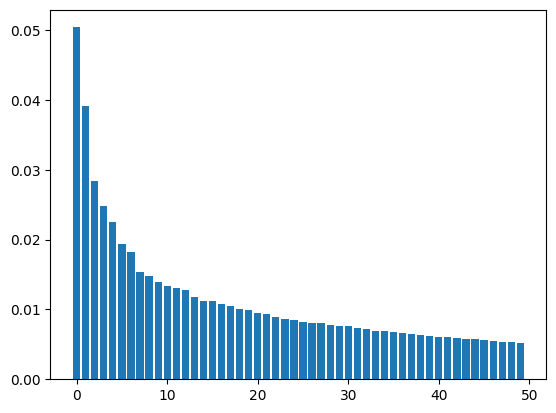

In [17]:
# Apply Principal Component Analysis (PCA) to the narrative embeddings
SE_matrix = np.array(sentence_embedding)

df2 = pd.DataFrame(SE_matrix)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df2)

scaled_data = scaler.transform(df2)

from sklearn.decomposition import PCA
NUM_PCA = 50
pca = PCA(n_components= NUM_PCA)
pca.fit(scaled_data)

# Plot the explained variances by principal components
plt.bar(range(NUM_PCA),pca.explained_variance_ratio_)

Text(0, 0.5, 'Second Principal Component')

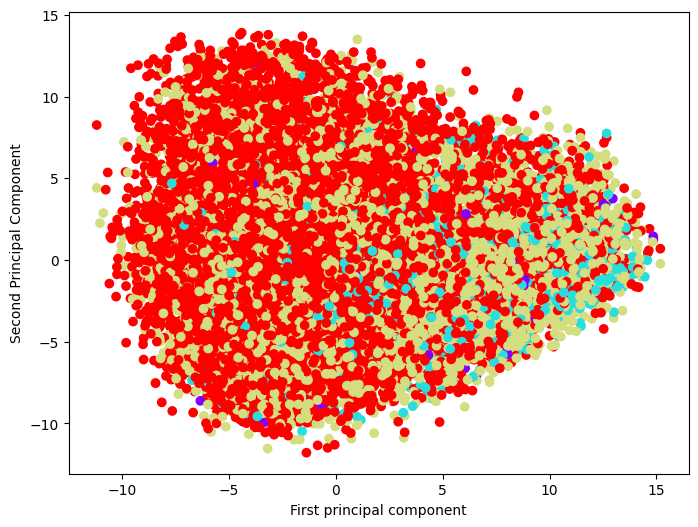

In [18]:
# Visualize the distribution of the narrative embeddings' projection on to the first two principal components

x_pca = pca.transform(scaled_data)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],
            c=df_trust_level_by_sentence,
            cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [ ]:
# Find and print out the narratives with the highest and lowest projections onto each Principal Component vector

import scipy.stats as stats

for n in range(NUM_PCA):
    print('PCA_%s' % n)
    #figure out percentiles
    pct_high = np.percentile(x_pca[:,n],99.75)  # The top 99.75 percentile (adjust to desired percentile)
    pct_low = np.percentile(x_pca[:,n],0.25)  # The lowest 0.25 percentile (adjust to desired percentile)
    
    index_high = np.array([i for i,fb in enumerate(fb_sentences) if x_pca[i,n] > pct_high],dtype='int')
    index_low = np.array([i for i,fb in enumerate(fb_sentences) if x_pca[i,n] < pct_low],dtype='int')
    
    print(np.mean([df_trust_level_by_sentence[a] for a in index_high]))  # The average entrustment level for the top 99.75 percentile
    print(np.mean([df_trust_level_by_sentence[a] for a in index_low]))  # THe average entrustment level for the lowest 0.25 percentile
    print(stats.ttest_ind(a=[df_trust_level_by_sentence[a] for a in index_high],
          b=[df_trust_level_by_sentence[a] for a in index_low],
          equal_var=False))
    
    print([fb for i,fb in enumerate(fb_sentences) if x_pca[i,n] > pct_high])
    print(' ')
    print([fb for i,fb in enumerate(fb_sentences) if x_pca[i,n] < pct_low])
    print('\n___\n')